# AAXJ

## Lendo arquivo de dados Ibovespa

In [1]:
import pandas as pd

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/AAXJ.csv')

## Pré - tratamento dos dados

In [2]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [3]:
df_arima = df_tratamento_dados(df)

# Separando os dados de treino e de teste

In [4]:
def split(df_arima, perc):
    train = df_arima[:int(len(df_arima)*perc)]
    test = df_arima[len(train):]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 0.8)

4086
1022


In [294]:
arima_train

,value
data,
2010-01-04,4.046029
2010-01-05,4.057162
2010-01-06,4.056296
2010-01-07,4.051437
2010-01-08,4.055430
...,...
2021-03-08,4.517540
2021-03-09,4.540952
2021-03-10,4.534533


## Decompondo a série

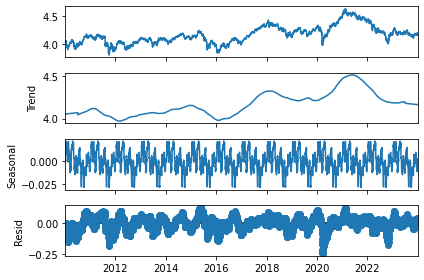

In [295]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(df_arima, model='additive',period=365,extrapolate_trend='freq')
result.plot()
plt.show()

## Verificando estacionariedade da série e da componente sasonal

In [296]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [297]:
# Componente sasonal
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


In [298]:
# série temporal
check_stationarity(arima_train['value'])

The series is NOT stationary


## Plotando os gráficos de ACF e PCF da série

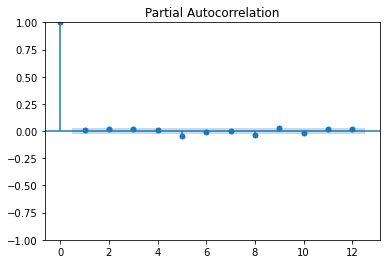

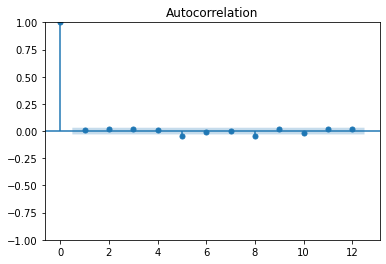

In [299]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(arima_train.diff().dropna(), lags =12)
plt.show()
plot_acf(arima_train.diff().dropna(), lags =12)
plt.show()

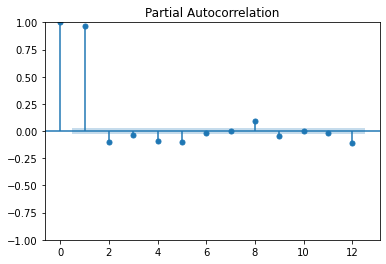

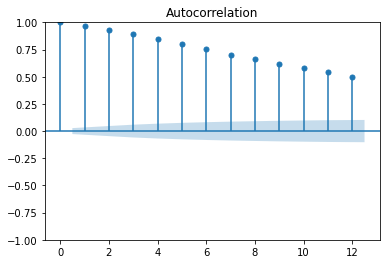

In [300]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()
plot_acf(seasonal, lags =12)
plt.show()

#### Analisando os gráficos pode ser visto que uma possível configuração pode ser pdq = 1,1,1 e PDQ = 0,0,1

In [5]:
ACF_PACF_config = [(0,1,0),(6,0,0, 12),'n']

# Parâmetros com auto arima

In [6]:
from pmdarima import auto_arima

# Suponha que 'data' seja a sua série temporal
auto_arima_config = auto_arima(arima_train, seasonal=True, m=12)  # m é o período da sazonalidade

In [7]:
# Obter os parâmetros 'order' e 'seasonal_order'
order = auto_arima_config.order
seasonal_order = auto_arima_config.seasonal_order
auto_arima_config = [order,seasonal_order,'n']
auto_arima_config

[(0, 1, 0), (0, 0, 0, 12), 'n']

##### O Auto Arima retornou como parãmetros pdq = 0,1,0 e PDQ = 0,0,0

# Parâmetros com grid search

## Carregando funções

In [11]:
import itertools
def sarima_parameter_search(inicio,search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = d = range(inicio, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio=0, search_range = 2)
total = len(order_combos)*len(seasonal_order_combos)
total

256

In [12]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
def seasonal_arima_model(time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            
            return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf

In [13]:
rmse,mae,mape,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 74.92033274528062 , mae-- 74.11370352250489 , mape-- 1.0
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 15.501967099437971 , mae-- 11.47507249480074 , mape-- 0.1390340544183719
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 42.40124798652617 , mae-- 38.56628859152234 , mape-- 0.563805133405105
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 12.634809787211754 , mae-- 11.71077154128635 , mape-- 0.16086399559460243
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 74.38626498788895 , mae-- 73.5367580410957 , mape-- 0.9938522386139867
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 15.204614751443668 , mae-- 11.256093184185453 , mape-- 0.13657462134970186
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 42.39077593168014 , mae-- 38.54540555577412 , mape-- 0.5635509024321776
order--  (0, 0, 0) , seasonal order--

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 37.56060655215969 , mae-- 33.009671199760845 , mape-- 0.4876058547512037


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 41.24628772850212 , mae-- 36.17297756606429 , mape-- 0.534368292564527
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 23.113577996534822 , mae-- 20.39309580008897 , mape-- 0.30135249436539235
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 28.75901005460645 , mae-- 25.389475237389316 , mape-- 0.3749895008725434
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 37.33301961513271 , mae-- 32.78383264259347 , mape-- 0.48438773642027644
order--  (0, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 41.042702067850634 , mae-- 35.96652715497857 , mape-- 0.5314424593759781
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 29.986961034064436 , mae-- 26.42566285650257 , mape-- 0.3904163856456706
order--  (0, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 14.58804742792222 , mae-- 12.642872659034108 , mape-- 0.18760953386355456
order--  (0, 0, 0)

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 37.675247256241725 , mae-- 33.14876472036123 , mape-- 0.48953523569469914
order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 11.991897823066896 , mae-- 10.925078746122193 , mape-- 0.147751649791467
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 23.112465326146822 , mae-- 20.391927921017228 , mape-- 0.30133581962515005
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 28.70020480507123 , mae-- 25.337160388390277 , mape-- 0.3742205249256171


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 37.417153941164756 , mae-- 32.9062078351951 , mape-- 0.4859951254788416
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 41.048993814698136 , mae-- 36.02504544444447 , mape-- 0.5320962316580139
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 23.155737366724168 , mae-- 20.43733237371491 , mape-- 0.301978354936145
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 29.118215397586965 , mae-- 25.717982448469126 , mape-- 0.3797824934214995
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 37.07207238117567 , mae-- 32.55871031717233 , mape-- 0.481061779349855


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 40.666867927784416 , mae-- 35.64356550347877 , mape-- 0.5266703249590146
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 74.88342361012299 , mae-- 74.07706668576358 , mape-- 0.9996109913278689
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 15.48715326817405 , mae-- 11.465786291215725 , mape-- 0.13893141372099513
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 42.391186264282034 , mae-- 38.55668234462742 , mape-- 0.5636672821764741
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 12.623668391422074 , mae-- 11.699959704646487 , mape-- 0.1606946963086974
order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 74.36682200690144 , mae-- 73.51303677170606 , mape-- 0.9935945630052776
order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 15.201736387026102 , mae-- 11.255664245249188 , mape-- 0.13657069170860406
order--  (0, 0, 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 12.527894309705244 , mae-- 11.628791139547088 , mape-- 0.16016664256706248
order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 22.76800265541216 , mae-- 20.03295931366466 , mape-- 0.2963467109007129
order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 27.96265437421066 , mae-- 24.620693600826062 , mape-- 0.3640039828070078
order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 36.04881336467169 , mae-- 31.600323087500765 , mape-- 0.46723108199447166
order--  (0, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 39.466327408835916 , mae-- 34.53168445889388 , mape-- 0.5105812453708206
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 23.317630340321966 , mae-- 20.613318584554506 , mape-- 0.30450844307048847
order--  (0, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 29.062748085130952 , mae-- 25.704359387501032 , mape-- 0.37949389856569576
order--  (0,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 8.509156035711735 , mae-- 7.04627638505385 , mape-- 0.10492610234970369


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 37.56290169176523 , mae-- 32.97444464368086 , mape-- 0.48731914207935284
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 12.005739720599857 , mae-- 10.803882374639807 , mape-- 0.14477226345928065
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 30.735031370641828 , mae-- 27.1547022775044 , mape-- 0.40093066889337775


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 5.386648670225423 , mae-- 4.50028856214446 , mape-- 0.06353515957779696


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 19.999260357679987 , mae-- 17.596012362345665 , mape-- 0.25889250654918666


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 13.424042740188458 , mae-- 12.501831727449389 , mape-- 0.17607896156600197
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 23.210099323563124 , mae-- 20.499762657537055 , mape-- 0.30291007857102814
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 28.776021359834935 , mae-- 25.427967210260228 , mape-- 0.37551981485227126
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 36.95055480334861 , mae-- 32.52338620851744 , mape-- 0.4803078951263179
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 39.848597430859556 , mae-- 35.01528091654649 , mape-- 0.5171332839023883
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 23.376349543046015 , mae-- 20.675132781498984 , mape-- 0.3053790306459309
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 29.330403473629023 , mae-- 25.958359369594614 , mape-- 0.38316077210635985
order--  (

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 37.11964380084813 , mae-- 32.54313846405987 , mape-- 0.4811918239135303


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 40.58101144463437 , mae-- 35.51157081852653 , mape-- 0.5250722366336752
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 22.745291787192123 , mae-- 19.992059942733803 , mape-- 0.2959615030227575
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 27.907664737607636 , mae-- 24.541095658062204 , mape-- 0.36306881668689817
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 37.07013205818 , mae-- 32.49095992629187 , mape-- 0.48045969704633884
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 40.53026479570639 , mae-- 35.45776777160053 , mape-- 0.5243183384314077
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 95.64833121565526 , mae-- 82.08030822538774 , mape-- 1.2049045853875553
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 105.19985881577492 , mae-- 89.37548164978793 , mape-- 1.3146255237481042


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 133.73596992542093 , mae-- 110.88982927674728 , mape-- 1.6384316768450995


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 149.97075620658674 , mae-- 122.9814709584693 , mape-- 1.8205455216592175
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 28.047152925717395 , mae-- 24.682510010221577 , mape-- 0.3650729021826451
order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 40.1069914603828 , mae-- 35.12092696773973 , mape-- 0.5192340876207825


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 42.9735879642214 , mae-- 30.718498431311932 , mape-- 0.4590053511772106


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 60.355181097693546 , mae-- 43.70564170153999 , mape-- 0.6543115484012573
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 22.74396975197918 , mae-- 19.99067605347522 , mape-- 0.2959420390532529
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 27.956939335347577 , mae-- 24.584164304053676 , mape-- 0.36370476118110134


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 37.07280794480723 , mae-- 32.495198986580625 , mape-- 0.4805144390015432
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 40.576507930529395 , mae-- 35.499460322324 , mape-- 0.5249262202686364
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 22.75618366624242 , mae-- 20.00335912588571 , mape-- 0.29612079033545335
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 27.76169847502173 , mae-- 24.414857009064274 , mape-- 0.3611989312866569


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 35.49617781729941 , mae-- 31.126890338804067 , mape-- 0.4603324369418312


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 38.57092518681071 , mae-- 33.766167510523154 , mape-- 0.4993529091963956
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 145.88008516759086 , mae-- 125.6945844178934 , mape-- 1.8465072720904019
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 147.47932217894896 , mae-- 126.9230056089679 , mape-- 1.8649781376806893
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 213.23765560749337 , mae-- 176.76939596351968 , mape-- 2.6148928203788553


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 224.0673192056143 , mae-- 184.85688467043752 , mape-- 2.736671431263995
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 28.04716681269008 , mae-- 24.682523192709606 , mape-- 0.3650730923345003
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 38.361837187523506 , mae-- 33.6163193576025 , mape-- 0.49702179276169056


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 61.91029576317689 , mae-- 48.14882030419013 , mape-- 0.7149426400984048


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 77.895964665662 , mae-- 60.03452176195691 , mape-- 0.8937409393046323
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 22.742641304210164 , mae-- 19.989291391949827 , mape-- 0.2959225447305248
order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 27.84891557914474 , mae-- 24.48909353204441 , mape-- 0.36230374232726853


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 36.893267934420116 , mae-- 32.33983496190038 , mape-- 0.4782213886215586


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 40.41821260373193 , mae-- 35.362892886620195 , mape-- 0.5229103190600496
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 22.717477731810266 , mae-- 19.963039939748317 , mape-- 0.29555299070539437
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 27.838673377568163 , mae-- 24.475133887579954 , mape-- 0.3621190914174469


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 36.85605652761031 , mae-- 32.29827131853698 , mape-- 0.477646015081075


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 40.380274916231876 , mae-- 35.32008389603684 , mape-- 0.5223188946061911
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 98.2563537754386 , mae-- 84.34914697339664 , mape-- 1.2382691562746386
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 109.428278518736 , mae-- 92.88100799791478 , mape-- 1.366590207141427


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 136.58525700602672 , mae-- 113.35373033963592 , mape-- 1.6747182245654428
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 147.01704519902358 , mae-- 121.13013917868409 , mape-- 1.7918396868862132
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 27.93451689210137 , mae-- 24.578787458311943 , mape-- 0.36356402479259536
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 40.618716155241486 , mae-- 35.55456219446237 , mape-- 0.5256639558819504


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , rmse-- 43.78284515615155 , mae-- 31.435954493698894 , mape-- 0.46958890700694317


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 54.95947857139575 , mae-- 39.78889074972193 , mape-- 0.5952023598074986
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 22.716259929884757 , mae-- 19.96176429701248 , mape-- 0.29553505062963775
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 27.92115299895359 , mae-- 24.5474055907048 , mape-- 0.3631854825671577


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 37.04146574381096 , mae-- 32.461246561506 , mape-- 0.48004110132412126
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 40.60748984682433 , mae-- 35.518679102331475 , mape-- 0.5252396314386026
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 22.749609224924924 , mae-- 19.996550396062688 , mape-- 0.2960247630541824
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 27.753411770127762 , mae-- 24.406447511795196 , mape-- 0.3610797691651487


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 35.291625300587704 , mae-- 30.94251226857167 , mape-- 0.457640351487854


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 38.422855336634655 , mae-- 33.63038813839623 , mape-- 0.49738015215488635
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 146.1086320587023 , mae-- 125.89360052169039 , mape-- 1.849432441573032
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 147.69536768118624 , mae-- 127.11240443326656 , mape-- 1.8677587822923878


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 214.94577788420648 , mae-- 178.2385250530586 , mape-- 2.6365410533282048


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 221.90405333628723 , mae-- 183.43681639150986 , mape-- 2.714815112853127
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 27.934533569169286 , mae-- 24.578803520311205 , mape-- 0.3635642555766543
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 40.31447222836043 , mae-- 35.29131393027803 , mape-- 0.5217823791527907


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , rmse-- 62.818039517930906 , mae-- 48.93676594839258 , mape-- 0.7265567623854033


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , rmse-- 73.09592578385426 , mae-- 56.58083934883735 , mape-- 0.8415475326792854
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , rmse-- 29.754747490233946 , mae-- 26.149919162307384 , mape-- 0.3868313156112529
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , rmse-- 15.725959500759581 , mae-- 13.645358481597388 , mape-- 0.202645718102775


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , rmse-- 38.246718054502566 , mae-- 33.5426398701434 , mape-- 0.4958587710481872


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , rmse-- 17.636519563436178 , mae-- 14.984196636081156 , mape-- 0.22400209802320906


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , rmse-- 30.73344985368073 , mae-- 26.989274375092897 , mape-- 0.39927675160449116


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , rmse-- 5.173262408123275 , mae-- 4.230014084866261 , mape-- 0.05758504611717986


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , rmse-- 41.3113087506498 , mae-- 37.15773086268342 , mape-- 0.5450941329030516


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , rmse-- 18.307032900328014 , mae-- 16.07220591744752 , mape-- 0.23803929813305624
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , rmse-- 20.971313774738682 , mae-- 18.24487043690287 , mape-- 0.27079019141092775
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , rmse-- 25.776784802079163 , mae-- 22.43363089284581 , mape-- 0.3328339145376751
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , rmse-- 34.12054604524016 , mae-- 29.586613942156884 , mape-- 0.4388669456026633
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'ct'] , rmse-- 37.267963010927254 , mae-- 32.25554257980587 , mape-- 0.47845575738623175
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'n'] , rmse-- 15.784727355392931 , mae-- 13.703948260826346 , mape-- 0.20348316920142728
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'c'] , rmse-- 17.562466751677167 , mae-- 14.927650484366799 , mape-- 0.2231373797289733
order--  (1,

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , rmse-- 37.24164139192193 , mae-- 32.22924889287715 , mape-- 0.4780739057679815
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , rmse-- 29.531679994995386 , mae-- 25.949446407790806 , mape-- 0.38389721794577514
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , rmse-- 13.826692672436614 , mae-- 11.888276160775755 , mape-- 0.17687509391100525


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , rmse-- 41.83135276411614 , mae-- 37.09678358401617 , mape-- 0.5466101312169601
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , rmse-- 16.251514397606883 , mae-- 14.070078187017858 , mape-- 0.20780275007406204


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , rmse-- 30.108677688315726 , mae-- 26.440274366625168 , mape-- 0.39119342883701214
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , rmse-- 12.063015791086697 , mae-- 10.238761680733367 , mape-- 0.1526959469025171
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , rmse-- 38.18320848722852 , mae-- 33.57426295629181 , mape-- 0.4960696586448167
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , rmse-- 8.90038398810541 , mae-- 7.672013793759558 , mape-- 0.10216852298825757
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , rmse-- 19.27188940967513 , mae-- 16.646606491570974 , mape-- 0.2475527033311572
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , rmse-- 24.760273734586306 , mae-- 21.391743883591392 , mape-- 0.3180288622693593


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , rmse-- 33.92185913037848 , mae-- 29.419577737995912 , mape-- 0.43638687291926176


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , rmse-- 36.99425151267343 , mae-- 32.025881822240294 , mape-- 0.47504501843191155
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , rmse-- 15.811084011856613 , mae-- 13.728199291315972 , mape-- 0.20383898020725227
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , rmse-- 17.590875557299654 , mae-- 14.955414510265085 , mape-- 0.22353887749273715
Could not fit with the designated model parameters


ValueError: not enough values to unpack (expected 5, got 3)

In [14]:
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

NameError: name 'grid_search_melhor_conf' is not defined

In [15]:
grid_search_melhor_conf = [(1, 0, 0), (0, 0, 1, 12), 'c']

##### O grid search retornou os parâmetros pdq = 0,1,0 e PDQ = 0,0,1

# Selecionando a melhor configuração

In [18]:
configs = [ACF_PACF_config, auto_arima_config,grid_search_melhor_conf]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,mae_pred,mape_pred,model_fit,predicao = seasonal_arima_model(arima_train, config[0], config[1], config[2],len(arima_test),"SARIMA")
    if rmse_pred <= rmse or mae_pred <= mae or mape_pred <= mape :
        melhor_model = model_fit
        mae=mae_pred
        mape = mape_pred 
        melhor_predicao =  predicao
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}, mae:{mae}, mape:{mape}")

RMSE da config: [(0, 1, 0), (6, 0, 0, 12), 'n']- rmse:22.586430117373446, mae:19.82641609545243, mape:0.2936287444091531
RMSE da config: [(0, 1, 0), (0, 0, 0, 12), 'n']- rmse:22.586430117373446, mae:19.82641609545243, mape:0.2936287444091531


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE da config: [(1, 0, 0), (0, 0, 1, 12), 'c']- rmse:5.173262408123275, mae:4.230014084866261, mape:0.05758504611717986


#### a melhor configuração é pdq = 0,1,0 e PDQ =0,0,1

In [114]:
rmse_pred,model_fit,melhor_predicao = seasonal_arima_model(arima_train, (1,0,1), (0,0,0,12),'c',len(arima_test))

TypeError: cannot unpack non-iterable NoneType object

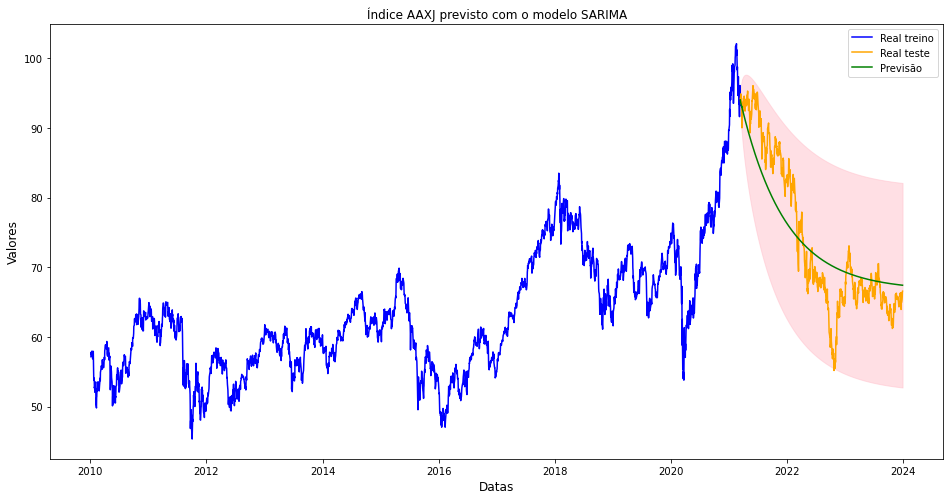

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model.get_forecast(steps=len(arima_test))
intervalo_confianca = previsoes.conf_int(alpha=0.05)
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice AAXJ previsto com o modelo SARIMA')

plt.legend()
plt.show()

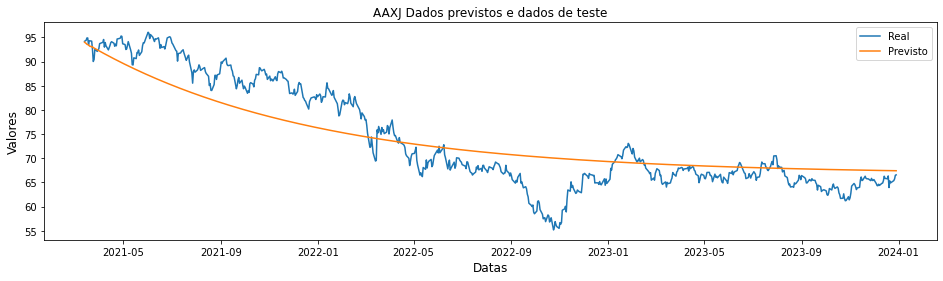

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Real")
plt.plot(melhor_predicao, label="Previsto")
plt.title('', fontsize=20)
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('AAXJ Dados previstos e dados de teste')
plt.legend()

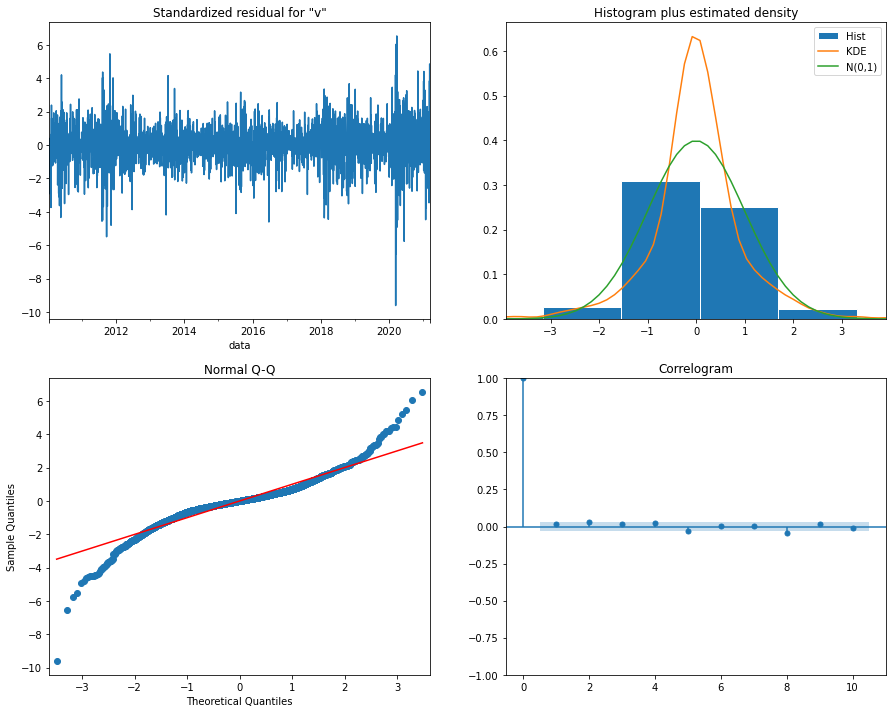

In [21]:
# Suponha que 'modelo_sarima' é o seu modelo SARIMA ajustado
melhor_model.plot_diagnostics(figsize=(15,12))
plt.show()

# Prophet

## carregando dados

In [27]:
df = ler_csv('dados/AAXJ.csv')
df_prophet = df_tratamento_dados(df)


In [314]:
len(df_prophet)

5108

## Adequando o df

In [28]:
df_prophet['ds'] = df_prophet.index.copy()
df_prophet.rename(columns={'value': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True, drop=True)
df_prophet.dropna(inplace=True)
df_prophet.tail(9)
len(df_prophet)

5108

## Separando treino e teste

In [29]:
prophet_train, prophet_test = split(df_prophet, 0.8) 


4086
1022


In [260]:
def split(df_arima, days):
    train = df_arima[:-days]
    test = df_arima[-days:]
    print(len(train))
    print(len(test))
    return train, test

prophet_train, prophet_test = split(df_prophet, 50)

5058
50


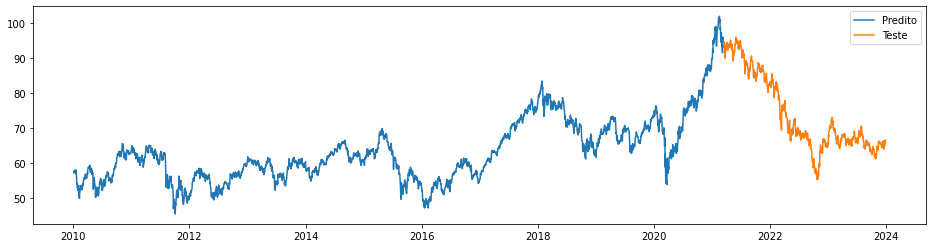

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
# Plotando o primeiro gráfico
plt.plot(prophet_train['ds'], prophet_train['y'], label='Predito')
# Plotando o segundo gráfico
plt.plot(prophet_test['ds'], prophet_test['y'], label='Teste')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

## Ajustando o modelo

In [31]:
# This function fits the prophet model to the input data and generates a forecast
from prophet import Prophet
def fit_and_forecast(df, periods, interval_width, changepoint_range=0.5):
    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)
    # Fit the model
    model.fit(df)
    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods,freq='D',include_history = False)
    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df
# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(prophet_train, len(prophet_test), 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

07:54:49 - cmdstanpy - INFO - Chain [1] start processing
07:54:50 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,72.309412,86.628422,79.675490
1,72.783780,86.043519,79.555486
2,72.294570,86.646934,79.453039
3,72.498550,86.428262,79.445895
4,72.239897,86.199747,79.405810


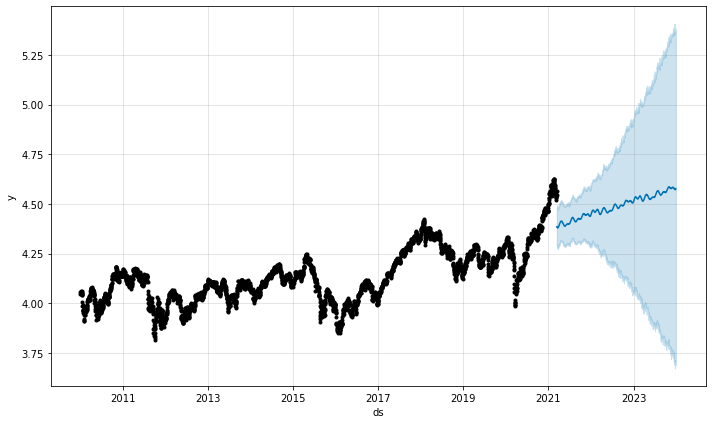

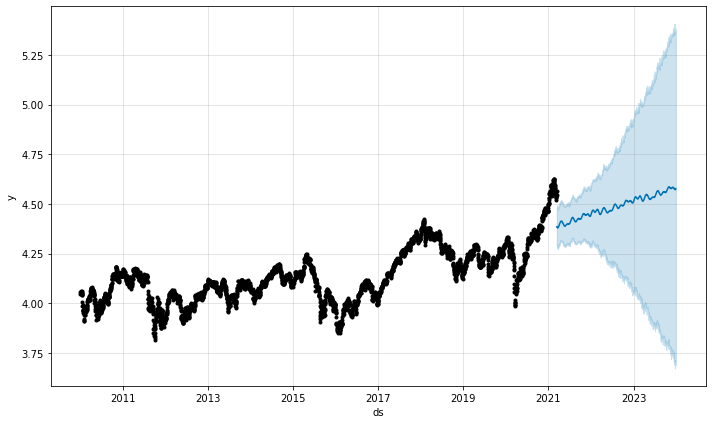

In [283]:
model.plot(forecast_df, uncertainty=True)

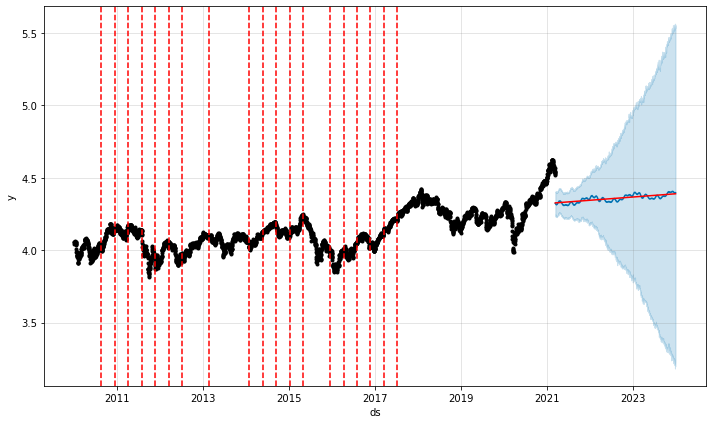

In [279]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

In [620]:
predicao = forecast_df[['ds','yhat']]
predicao = predicao[len(prophet_train):]

In [621]:
prophet_test

,y,ds
4596,106.472000,2022-08-05
4597,107.115333,2022-08-06
4598,107.758667,2022-08-07
4599,108.402000,2022-08-08
4600,108.651000,2022-08-09
...,...,...
5102,133.143000,2023-12-24
5103,133.338000,2023-12-25
5104,133.533000,2023-12-26
5105,134.194000,2023-12-27


In [623]:
rmse = np.sqrt(mean_squared_error(prophet_test['y'], predicao['yhat']))
rmse

7.821085174542876

## Ajuste de hiperparâmetros

In [107]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.03, 0.035, 0.04],
              'holidays_prior_scale': [5,10,15,20],
               'changepoint_range':[0.85,0.9],
              'n_changepoints' : [50,75,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 72


In [320]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [108]:
import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil


In [24]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'seasonality_prior_scale':[0.01,1,5,10,12],
               'changepoint_prior_scale':[0.001,0.05,0.08,0.5],
              'holidays_prior_scale': [5,10],
               'changepoint_range':[0.2],
              'n_changepoints' : [50,75]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 160


In [32]:
import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


07:54:57 - cmdstanpy - INFO - Chain [1] start processing
07:54:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  1.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


07:54:58 - cmdstanpy - INFO - Chain [1] start processing
07:54:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  1.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:59 - cmdstanpy - INFO - Chain [1] start processing
07:55:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  2.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:01 - cmdstanpy - INFO - Chain [1] start processing
07:55:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  3.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:02 - cmdstanpy - INFO - Chain [1] start processing
07:55:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  3.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:03 - cmdstanpy - INFO - Chain [1] start processing
07:55:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  4.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:05 - cmdstanpy - INFO - Chain [1] start processing
07:55:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  4.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:06 - cmdstanpy - INFO - Chain [1] start processing
07:55:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  5.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:09 - cmdstanpy - INFO - Chain [1] start processing
07:55:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  6.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:12 - cmdstanpy - INFO - Chain [1] start processing
07:55:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  6.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:15 - cmdstanpy - INFO - Chain [1] start processing
07:55:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  7.000000000000001
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:16 - cmdstanpy - INFO - Chain [1] start processing
07:55:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  7.000000000000001
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:18 - cmdstanpy - INFO - Chain [1] start processing
07:55:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  8.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  9.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:21 - cmdstanpy - INFO - Chain [1] start processing
07:55:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  9.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:25 - cmdstanpy - INFO - Chain [1] start processing
07:55:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  10.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:26 - cmdstanpy - INFO - Chain [1] start processing
07:55:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  11.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:28 - cmdstanpy - INFO - Chain [1] start processing
07:55:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  11.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:29 - cmdstanpy - INFO - Chain [1] start processing
07:55:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  12.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:32 - cmdstanpy - INFO - Chain [1] start processing
07:55:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  12.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:34 - cmdstanpy - INFO - Chain [1] start processing
07:55:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  13.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:36 - cmdstanpy - INFO - Chain [1] start processing
07:55:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  14.000000000000002
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:37 - cmdstanpy - INFO - Chain [1] start processing
07:55:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  14.000000000000002
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:38 - cmdstanpy - INFO - Chain [1] start processing
07:55:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  15.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:39 - cmdstanpy - INFO - Chain [1] start processing
07:55:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.589483335147166
total:  16.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:41 - cmdstanpy - INFO - Chain [1] start processing
07:55:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  16.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:42 - cmdstanpy - INFO - Chain [1] start processing
07:55:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  17.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:43 - cmdstanpy - INFO - Chain [1] start processing
07:55:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  17.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:45 - cmdstanpy - INFO - Chain [1] start processing
07:55:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  18.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:46 - cmdstanpy - INFO - Chain [1] start processing
07:55:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.704278830609864
total:  19.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:47 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  19.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:49 - cmdstanpy - INFO - Chain [1] start processing
07:55:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  20.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:50 - cmdstanpy - INFO - Chain [1] start processing
07:55:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  21.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:51 - cmdstanpy - INFO - Chain [1] start processing
07:55:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  21.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:53 - cmdstanpy - INFO - Chain [1] start processing
07:55:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.752388972714344
total:  22.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:54 - cmdstanpy - INFO - Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  23.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:55 - cmdstanpy - INFO - Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  23.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:57 - cmdstanpy - INFO - Chain [1] start processing
07:55:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  24.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:59 - cmdstanpy - INFO - Chain [1] start processing
07:56:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  24.0
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:02 - cmdstanpy - INFO - Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.814519765740098
total:  25.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:04 - cmdstanpy - INFO - Chain [1] start processing
07:56:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  26.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:05 - cmdstanpy - INFO - Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  26.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:07 - cmdstanpy - INFO - Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  27.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:09 - cmdstanpy - INFO - Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  28.000000000000004
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:11 - cmdstanpy - INFO - Chain [1] start processing
07:56:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  28.000000000000004
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:13 - cmdstanpy - INFO - Chain [1] start processing
07:56:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  28.999999999999996
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:21 - cmdstanpy - INFO - Chain [1] start processing
07:56:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  28.999999999999996
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:26 - cmdstanpy - INFO - Chain [1] start processing
07:56:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  30.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:30 - cmdstanpy - INFO - Chain [1] start processing
07:56:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  31.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:35 - cmdstanpy - INFO - Chain [1] start processing
07:56:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  31.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:40 - cmdstanpy - INFO - Chain [1] start processing
07:56:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  32.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:42 - cmdstanpy - INFO - Chain [1] start processing
07:56:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  33.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:45 - cmdstanpy - INFO - Chain [1] start processing
07:56:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  33.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:48 - cmdstanpy - INFO - Chain [1] start processing
07:56:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  34.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:50 - cmdstanpy - INFO - Chain [1] start processing
07:56:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  34.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:56 - cmdstanpy - INFO - Chain [1] start processing
07:57:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  35.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:04 - cmdstanpy - INFO - Chain [1] start processing
07:57:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  36.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:10 - cmdstanpy - INFO - Chain [1] start processing
07:57:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  36.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:16 - cmdstanpy - INFO - Chain [1] start processing
07:57:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  37.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:23 - cmdstanpy - INFO - Chain [1] start processing
07:57:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  38.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:32 - cmdstanpy - INFO - Chain [1] start processing
07:57:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  38.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:34 - cmdstanpy - INFO - Chain [1] start processing
07:57:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  39.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:38 - cmdstanpy - INFO - Chain [1] start processing
07:57:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  39.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:41 - cmdstanpy - INFO - Chain [1] start processing
07:57:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  40.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:43 - cmdstanpy - INFO - Chain [1] start processing
07:57:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.92902720134618
total:  41.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:45 - cmdstanpy - INFO - Chain [1] start processing
07:57:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  41.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:49 - cmdstanpy - INFO - Chain [1] start processing
07:57:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  42.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:54 - cmdstanpy - INFO - Chain [1] start processing
07:58:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  42.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:01 - cmdstanpy - INFO - Chain [1] start processing
07:58:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  43.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:06 - cmdstanpy - INFO - Chain [1] start processing
07:58:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997216410230717
total:  44.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:10 - cmdstanpy - INFO - Chain [1] start processing
07:58:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  44.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:13 - cmdstanpy - INFO - Chain [1] start processing
07:58:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  45.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:16 - cmdstanpy - INFO - Chain [1] start processing
07:58:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  46.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:21 - cmdstanpy - INFO - Chain [1] start processing
07:58:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  46.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:25 - cmdstanpy - INFO - Chain [1] start processing
07:58:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.923738315354703
total:  47.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:28 - cmdstanpy - INFO - Chain [1] start processing
07:58:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  47.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:37 - cmdstanpy - INFO - Chain [1] start processing
07:58:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  48.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:43 - cmdstanpy - INFO - Chain [1] start processing
07:58:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  49.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:48 - cmdstanpy - INFO - Chain [1] start processing
07:58:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  49.0
{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:54 - cmdstanpy - INFO - Chain [1] start processing
07:59:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.993025084913802
total:  50.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:02 - cmdstanpy - INFO - Chain [1] start processing
07:59:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  51.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:07 - cmdstanpy - INFO - Chain [1] start processing
07:59:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  51.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:10 - cmdstanpy - INFO - Chain [1] start processing
07:59:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  52.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:13 - cmdstanpy - INFO - Chain [1] start processing
07:59:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  53.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:15 - cmdstanpy - INFO - Chain [1] start processing
07:59:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  53.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:20 - cmdstanpy - INFO - Chain [1] start processing
07:59:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  54.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
07:59:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  54.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
07:59:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  55.00000000000001
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:31 - cmdstanpy - INFO - Chain [1] start processing
07:59:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  56.00000000000001
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:39 - cmdstanpy - INFO - Chain [1] start processing
07:59:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  56.00000000000001
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:42 - cmdstanpy - INFO - Chain [1] start processing
07:59:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  56.99999999999999
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:45 - cmdstanpy - INFO - Chain [1] start processing
07:59:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  56.99999999999999
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:48 - cmdstanpy - INFO - Chain [1] start processing
07:59:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  57.99999999999999
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:51 - cmdstanpy - INFO - Chain [1] start processing
07:59:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  59.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:57 - cmdstanpy - INFO - Chain [1] start processing
07:59:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  59.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:00 - cmdstanpy - INFO - Chain [1] start processing
08:00:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  60.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:05 - cmdstanpy - INFO - Chain [1] start processing
08:00:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  61.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:13 - cmdstanpy - INFO - Chain [1] start processing
08:00:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  61.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:20 - cmdstanpy - INFO - Chain [1] start processing
08:00:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  62.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:26 - cmdstanpy - INFO - Chain [1] start processing
08:00:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  62.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:32 - cmdstanpy - INFO - Chain [1] start processing
08:00:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  63.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:36 - cmdstanpy - INFO - Chain [1] start processing
08:00:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  64.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:41 - cmdstanpy - INFO - Chain [1] start processing
08:00:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  64.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:44 - cmdstanpy - INFO - Chain [1] start processing
08:00:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  65.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:46 - cmdstanpy - INFO - Chain [1] start processing
08:00:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.9385393659538
total:  66.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:49 - cmdstanpy - INFO - Chain [1] start processing
08:00:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  66.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:52 - cmdstanpy - INFO - Chain [1] start processing
08:00:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:56 - cmdstanpy - INFO - Chain [1] start processing
08:01:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:03 - cmdstanpy - INFO - Chain [1] start processing
08:01:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:07 - cmdstanpy - INFO - Chain [1] start processing
08:01:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.997582552704884
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:10 - cmdstanpy - INFO - Chain [1] start processing
08:01:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:14 - cmdstanpy - INFO - Chain [1] start processing
08:01:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:19 - cmdstanpy - INFO - Chain [1] start processing
08:01:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:22 - cmdstanpy - INFO - Chain [1] start processing
08:01:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:25 - cmdstanpy - INFO - Chain [1] start processing
08:01:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.930510625036913
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:28 - cmdstanpy - INFO - Chain [1] start processing
08:01:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:39 - cmdstanpy - INFO - Chain [1] start processing
08:01:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:50 - cmdstanpy - INFO - Chain [1] start processing
08:01:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:59 - cmdstanpy - INFO - Chain [1] start processing
08:02:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:09 - cmdstanpy - INFO - Chain [1] start processing
08:02:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.989183151838901
total:  75.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:21 - cmdstanpy - INFO - Chain [1] start processing
08:02:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  76.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:23 - cmdstanpy - INFO - Chain [1] start processing
08:02:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  76.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:29 - cmdstanpy - INFO - Chain [1] start processing
08:02:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  77.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:33 - cmdstanpy - INFO - Chain [1] start processing
08:02:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  78.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:35 - cmdstanpy - INFO - Chain [1] start processing
08:02:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  78.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:40 - cmdstanpy - INFO - Chain [1] start processing
08:02:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  79.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:47 - cmdstanpy - INFO - Chain [1] start processing
08:02:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  79.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
08:02:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  80.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:57 - cmdstanpy - INFO - Chain [1] start processing
08:02:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  81.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:00 - cmdstanpy - INFO - Chain [1] start processing
08:03:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  81.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:04 - cmdstanpy - INFO - Chain [1] start processing
08:03:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  82.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:08 - cmdstanpy - INFO - Chain [1] start processing
08:03:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  82.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:12 - cmdstanpy - INFO - Chain [1] start processing
08:03:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  83.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:20 - cmdstanpy - INFO - Chain [1] start processing
08:03:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  84.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:25 - cmdstanpy - INFO - Chain [1] start processing
08:03:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  84.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:29 - cmdstanpy - INFO - Chain [1] start processing
08:03:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  85.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:33 - cmdstanpy - INFO - Chain [1] start processing
08:03:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  86.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:39 - cmdstanpy - INFO - Chain [1] start processing
08:03:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  86.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:43 - cmdstanpy - INFO - Chain [1] start processing
08:03:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  87.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:46 - cmdstanpy - INFO - Chain [1] start processing
08:03:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  88.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:53 - cmdstanpy - INFO - Chain [1] start processing
08:03:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  88.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:55 - cmdstanpy - INFO - Chain [1] start processing
08:03:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  89.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:00 - cmdstanpy - INFO - Chain [1] start processing
08:04:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  89.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:03 - cmdstanpy - INFO - Chain [1] start processing
08:04:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  90.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:06 - cmdstanpy - INFO - Chain [1] start processing
08:04:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.952180952751181
total:  91.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:08 - cmdstanpy - INFO - Chain [1] start processing
08:04:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  91.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:11 - cmdstanpy - INFO - Chain [1] start processing
08:04:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  92.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:14 - cmdstanpy - INFO - Chain [1] start processing
08:04:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  93.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:21 - cmdstanpy - INFO - Chain [1] start processing
08:04:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  93.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:24 - cmdstanpy - INFO - Chain [1] start processing
08:04:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.973923875245884
total:  94.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:28 - cmdstanpy - INFO - Chain [1] start processing
08:04:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  94.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:32 - cmdstanpy - INFO - Chain [1] start processing
08:04:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  95.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:40 - cmdstanpy - INFO - Chain [1] start processing
08:04:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  96.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:44 - cmdstanpy - INFO - Chain [1] start processing
08:04:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  96.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:48 - cmdstanpy - INFO - Chain [1] start processing
08:04:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.951903910294396
total:  97.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:52 - cmdstanpy - INFO - Chain [1] start processing
08:04:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  97.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:56 - cmdstanpy - INFO - Chain [1] start processing
08:04:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  98.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:59 - cmdstanpy - INFO - Chain [1] start processing
08:05:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  99.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:08 - cmdstanpy - INFO - Chain [1] start processing
08:05:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  99.0
{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.2, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12}


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:12 - cmdstanpy - INFO - Chain [1] start processing
08:05:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.96143137179759
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_11468\1416017460.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [34]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,12.589483,"{'changepoint_prior_scale': 0.001, 'changepoin...",11.579502,0.158467
1,12.589483,"{'changepoint_prior_scale': 0.001, 'changepoin...",11.579502,0.158467
2,12.589483,"{'changepoint_prior_scale': 0.001, 'changepoin...",11.579502,0.158467
3,12.589483,"{'changepoint_prior_scale': 0.001, 'changepoin...",11.579502,0.158467
4,12.589483,"{'changepoint_prior_scale': 0.001, 'changepoin...",11.579502,0.158467


In [35]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 12.589483335147166
MAE: 11.579501627169579
MAPE: 0.15846737939806035
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


In [252]:
best_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Confraternização Universal,Confraternização Universal_lower,Confraternização Universal_upper,Dia do Trabalhador,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-13,0.381995,0.354002,0.410572,0.381995,0.381995,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.000770,-0.000770,-0.000770,0.0,0.0,0.0,0.381225
1,2021-03-14,0.382012,0.350323,0.410512,0.382012,0.382012,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001041,-0.001041,-0.001041,0.0,0.0,0.0,0.380971
2,2021-03-15,0.382029,0.350916,0.410061,0.382029,0.382031,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001288,-0.001288,-0.001288,0.0,0.0,0.0,0.380741
3,2021-03-16,0.382047,0.350352,0.409150,0.382036,0.382058,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001509,-0.001509,-0.001509,0.0,0.0,0.0,0.380537
4,2021-03-17,0.382064,0.348935,0.409003,0.382041,0.382090,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001701,-0.001701,-0.001701,0.0,0.0,0.0,0.380363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2023-12-25,0.399633,0.195166,0.601518,0.197827,0.600249,0.0,0.0,0.0,0.0,...,-0.000157,-0.000157,-0.000157,-0.001148,-0.001148,-0.001148,0.0,0.0,0.0,0.398329
1018,2023-12-26,0.399651,0.193627,0.603760,0.197576,0.600552,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001113,-0.001113,-0.001113,0.0,0.0,0.0,0.398538
1019,2023-12-27,0.399668,0.200647,0.602923,0.197325,0.600854,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.001044,-0.001044,-0.001044,0.0,0.0,0.0,0.398625
1020,2023-12-28,0.399685,0.193331,0.605447,0.197077,0.601157,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.000939,-0.000939,-0.000939,0.0,0.0,0.0,0.398746


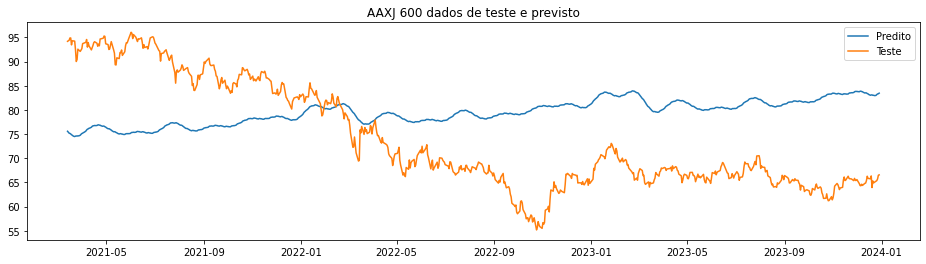

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
# Plotando o primeiro gráfico
plt.plot(predicao['ds'], predicao['yhat'], label='Predito')
# Plotando o segundo gráfico
plt.plot(prophet_test['ds'], prophet_test['y'], label='Teste')
# Adicionando uma legenda
plt.legend()
plt.title('AAXJ 600 dados de teste e previsto')
# Exibindo o gráfico
plt.show()

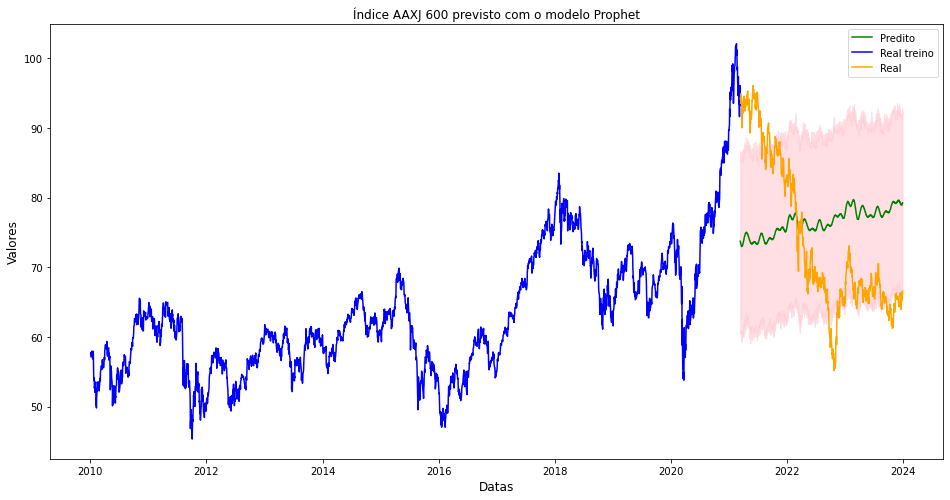

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')

# Área do intervalo de confiança
plt.fill_between(best_prediction['ds'],
                 best_prediction['yhat_upper'],
                 best_prediction['yhat_lower'], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice AAXJ 600 previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [ ]:
cros_validation(model)